## Predicting Covid Death Rate by Country - the influence of lockdowns, vaccinations and Human Development Index

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
import seaborn as sn
import matplotlib.pyplot as plt
import shap
import geopandas
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
shap.initjs()

## Reading data

In [116]:
data = pd.read_csv('owid-covid-data.csv', sep=';', header=1)

In [117]:
data.head(5)

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
0,AFG,Asia,Afghanistan,2020-02-24,5.0,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
1,AFG,Asia,Afghanistan,2020-02-25,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
2,AFG,Asia,Afghanistan,2020-02-26,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
3,AFG,Asia,Afghanistan,2020-02-27,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
4,AFG,Asia,Afghanistan,2020-02-28,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN


In [118]:
data.describe()

,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,...,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
count,1.466460e+05,146640.000000,145495.000000,1.296280e+05,129823.000000,145495.000000,145961.000000,145955.000000,144815.000000,128956.000000,...,95299.000000,93925.000000,61608.000000,111162.000000,139297.000000,122504.000000,5125.000000,5125.000000,5125.000000,5125.000000
mean,2.056253e+06,7902.873622,7898.601209,5.137389e+04,171.771058,152.651993,22369.716130,96.659239,96.390301,442.395979,...,10.585822,32.755386,50.827606,3.027388,73.598735,0.725955,33933.533385,8.989011,16.209239,849.068933
std,1.220401e+07,43174.456551,42467.859042,2.705090e+05,836.771109,773.443843,36569.122494,299.270704,215.300148,704.674574,...,10.499769,13.519378,31.815469,2.453571,7.490805,0.150003,95909.379877,16.682299,31.277328,1264.970282
min,1.000000e+00,-74347.000000,-6223.000000,1.000000e+00,-1918.000000,-232.143000,0.001000,-3125.829000,-272.971000,0.000000,...,0.100000,7.700000,1.188000,0.100000,53.280000,0.394000,-31959.400000,-28.450000,-95.920000,-1745.051271
25%,1.473000e+03,1.000000,5.571000,6.500000e+01,0.000000,0.000000,484.678000,0.021000,1.395000,15.038000,...,1.900000,21.600000,19.351000,1.300000,69.500000,0.602000,-98.400000,-0.870000,-0.580000,-38.847199
50%,1.940550e+04,67.000000,87.857000,6.490000e+02,2.000000,1.286000,3876.958000,9.680000,15.284000,101.185000,...,6.300000,31.400000,49.839000,2.400000,75.050000,0.743000,2609.300000,5.510000,7.140000,404.628241
75%,2.456122e+05,899.250000,950.785500,6.285000e+03,19.000000,15.000000,28911.751000,83.538000,96.064000,595.150250,...,19.300000,41.300000,83.241000,4.000000,78.930000,0.845000,21491.200000,13.880000,22.620000,1437.343286
max,2.771612e+08,908289.000000,827220.000000,5.377197e+06,18007.000000,14703.143000,276288.233000,51427.491000,7406.207000,6066.503000,...,44.000000,78.100000,100.000000,13.800000,86.750000,0.957000,984309.300000,115.000000,374.200000,7733.995683


In [320]:
death_stats = data[data['date']=='2021-12-01'][['stringency_index', 'location','cardiovasc_death_rate','population','iso_code','total_deaths_per_million']].dropna()

In [268]:
top_countries = death_stats[death_stats.population >= 20000000].sort_values(by='total_deaths_per_million', ascending=False).head(20).location.tolist()

In [269]:
top_countries

['Peru',
 'Brazil',
 'South America',
 'Argentina',
 'Colombia',
 'United States',
 'Mexico',
 'Poland',
 'Italy',
 'United Kingdom',
 'Ukraine',
 'North America',
 'Europe',
 'European Union',
 'Spain',
 'Russia',
 'France',
 'Iran',
 'High income',
 'South Africa']

In [270]:
bottom_countries = death_stats[death_stats.population >= 20000000].sort_values(by='total_deaths_per_million', ascending=True).head(40).location.tolist()

In [271]:
bottom_countries

['China',
 'Niger',
 'Tanzania',
 'Democratic Republic of Congo',
 'Burkina Faso',
 'Nigeria',
 "Cote d'Ivoire",
 'Mali',
 'Madagascar',
 'Taiwan',
 'Ghana',
 'Uzbekistan',
 'Angola',
 'Low income',
 'Ethiopia',
 'Mozambique',
 'Yemen',
 'Cameroon',
 'Uganda',
 'Sudan',
 'South Korea',
 'Australia',
 'Kenya',
 'Oceania',
 'Pakistan',
 'Algeria',
 'Japan',
 'Africa',
 'Bangladesh',
 'Venezuela',
 'Afghanistan',
 'Egypt',
 'Saudi Arabia',
 'Vietnam',
 'Asia',
 'Thailand',
 'India',
 'Lower middle income',
 'Myanmar',
 'Nepal']

In [309]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

In [321]:
world = world.merge(death_stats, left_on = "iso_a3", right_on = "iso_code", how='left')

<AxesSubplot:>

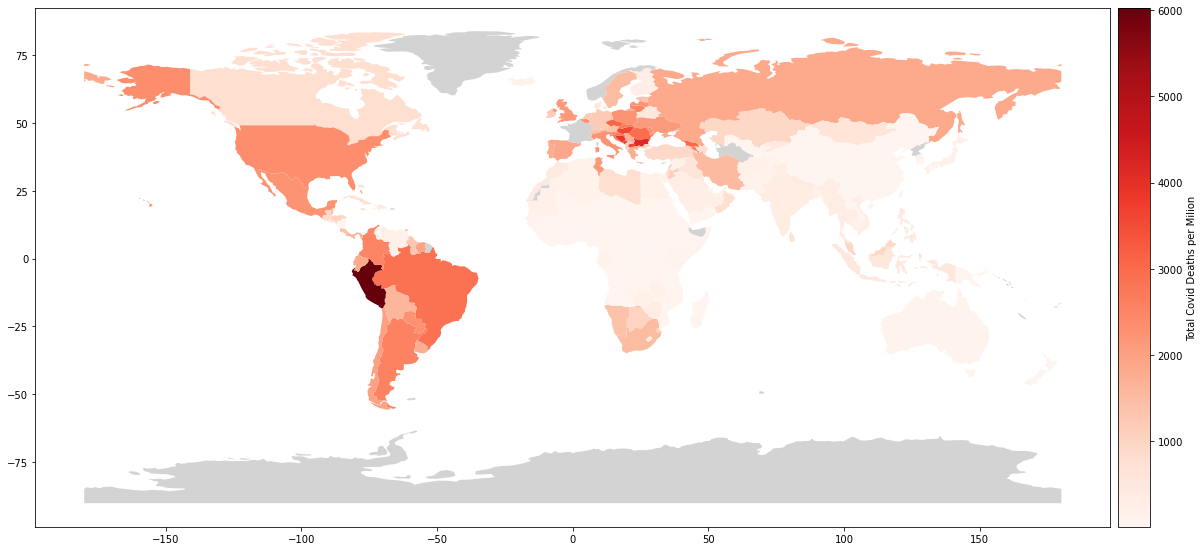

In [311]:
fig, ax = plt.subplots(1, 1, figsize=(20, 20))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.1)

world.plot(column = 'total_deaths_per_million', ax=ax, legend=True, cax=cax, 
           cmap='Reds', missing_kwds={'color': 'lightgrey'}, legend_kwds={'label': "Total Covid Deaths per Milion"})

## The highest numbers of covid-deaths per million are in South America and Central/Eastern Europe
## Grey indicates no latest data

<AxesSubplot:>

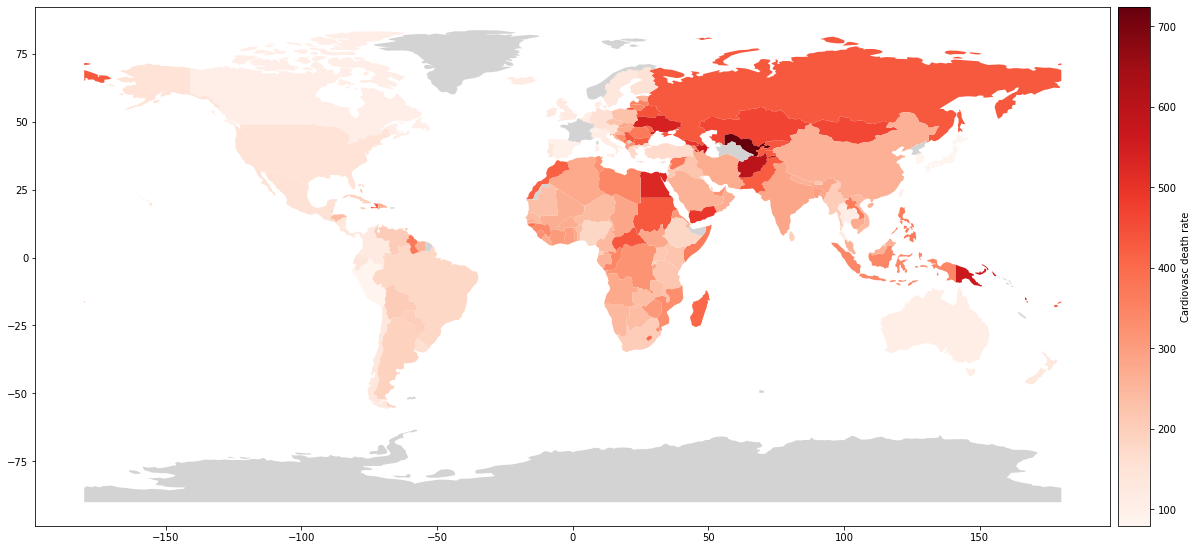

In [313]:
fig, ax = plt.subplots(1, 1, figsize=(20, 20))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.1)

world.plot(column = 'cardiovasc_death_rate', ax=ax, legend=True, cax=cax, 
           cmap='Reds', missing_kwds={'color': 'lightgrey'}, legend_kwds={'label': "Cardiovasc death rate"})

<AxesSubplot:>

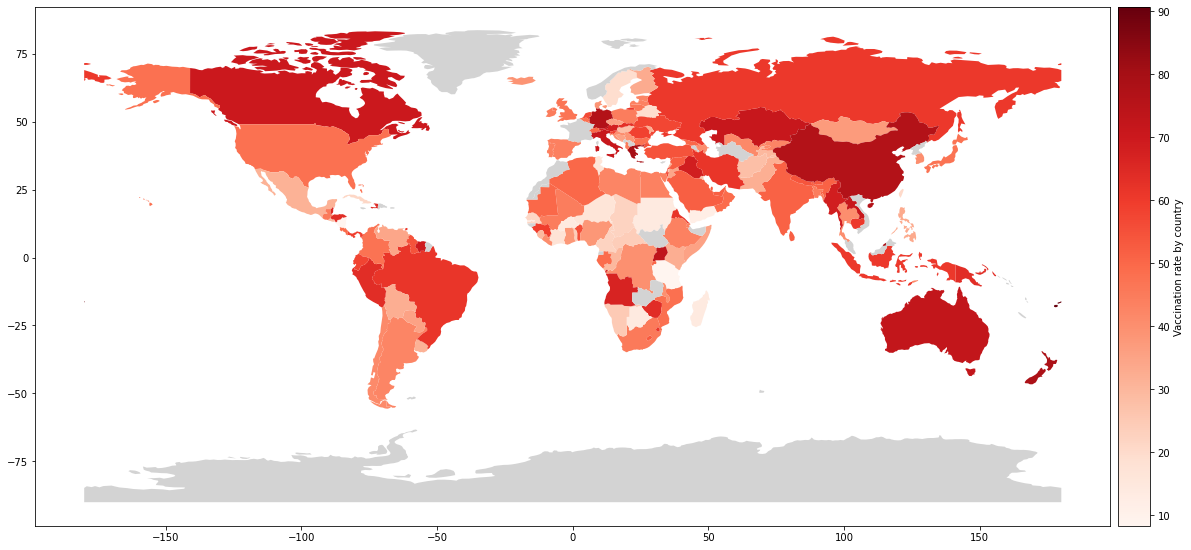

In [322]:
fig, ax = plt.subplots(1, 1, figsize=(20, 20))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.1)

world.plot(column = 'stringency_index', ax=ax, legend=True, cax=cax, 
           cmap='Reds', missing_kwds={'color': 'lightgrey'}, legend_kwds={'label': "Stringency index by country"})
#Lockdown by country (100-strick lockdown, 0-no restrictions)

## Basic data engineering

In [245]:
df = pd.DataFrame()

In [251]:
for loc in data.location.unique():
    temp = data[data['location']==loc]
    temp['targets']=temp['new_deaths_smoothed_per_million'].shift(30)
    temp = temp[temp['targets']>=0]
    temp = temp.fillna(method='ffill')
    temp = temp.fillna(method='bfill')
    df = df.append(temp)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [252]:
df = df[['location', 
       'total_vaccinations_per_hundred', 
       'new_vaccinations_smoothed_per_million', 'stringency_index',
       'population', 'population_density', 'median_age', 'aged_65_older',
       'aged_70_older', 'gdp_per_capita', 'extreme_poverty',
       'cardiovasc_death_rate', 'diabetes_prevalence', 'female_smokers',
       'male_smokers', 'hospital_beds_per_thousand', 'life_expectancy',
       'human_development_index','targets','continent','tests_units']]

In [253]:
df = df[~df['continent'].isna()]

In [258]:
df = df.dropna(axis=1, thresh=round(len(df)*0.5))

In [259]:
df.isna().sum()/len(df)*100

location                                  0.000000
total_vaccinations_per_hundred            1.997169
new_vaccinations_smoothed_per_million     1.997169
stringency_index                         14.274065
population                                0.000000
population_density                        4.985229
median_age                               11.005201
aged_65_older                            11.983013
aged_70_older                            11.483721
gdp_per_capita                           11.145218
extreme_poverty                          41.236614
cardiovasc_death_rate                    11.731444
diabetes_prevalence                       7.403219
female_smokers                           31.829302
male_smokers                             32.782496
hospital_beds_per_thousand               20.454056
life_expectancy                           0.472366
human_development_index                  12.126108
targets                                   0.000000
continent                      

In [260]:
df = df.dropna(axis=0)

In [261]:
len(df)

96902

In [262]:
df.describe() #Mean Death Rate per million people was 1.95, the max 28 and the min 0 (negative values were dropped)

,total_vaccinations_per_hundred,new_vaccinations_smoothed_per_million,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,hospital_beds_per_thousand,life_expectancy,human_development_index,targets
count,96902.000000,96902.000000,96902.000000,9.690200e+04,96902.000000,96902.000000,96902.000000,96902.00000,96902.000000,96902.000000,96902.000000,96902.000000,96902.000000,96902.000000,96902.000000,96902.000000,96902.000000,96902.000000
mean,27.758657,2022.905822,59.296684,7.969636e+07,148.182398,33.466655,11.020425,7.12016,20890.071541,8.115498,240.142590,6.832058,11.661549,32.756833,3.202397,74.919620,0.770701,1.913879
std,47.108635,2983.031997,16.984706,2.332529e+08,225.638764,8.681778,6.159460,4.32750,17874.757839,15.631508,112.164827,2.807491,10.078962,14.814481,2.364709,6.458608,0.134518,3.284073
min,0.000000,0.000000,0.000000,3.433600e+05,1.980000,16.400000,2.168000,1.30800,1095.042000,0.100000,85.998000,0.990000,0.300000,7.700000,0.300000,60.850000,0.456000,0.000000
25%,0.000000,82.000000,46.760000,5.460726e+06,42.729000,27.600000,5.732000,3.21200,6570.102000,0.500000,133.982000,4.820000,2.500000,20.600000,1.400000,70.780000,0.686000,0.047000
50%,0.670000,602.000000,59.260000,1.788847e+07,85.129000,33.500000,10.069000,5.69400,15524.995000,1.200000,227.349000,6.800000,7.300000,31.200000,2.540000,76.670000,0.783000,0.457000
75%,36.227500,2783.000000,72.220000,5.480601e+07,147.674000,41.200000,16.569000,10.79700,29524.265000,5.700000,318.991000,8.350000,19.800000,42.400000,4.485000,80.280000,0.888000,2.376000
max,224.730000,37684.000000,100.000000,1.444216e+09,1454.037000,47.900000,23.021000,16.24000,94277.965000,71.400000,539.849000,16.740000,35.300000,78.100000,12.270000,83.560000,0.957000,28.664000


In [263]:
one_hot_encoded_data = pd.get_dummies(df, columns = ['continent','tests_units'])

In [264]:
one_hot_encoded_data.columns

Index(['location', 'total_vaccinations_per_hundred',
       'new_vaccinations_smoothed_per_million', 'stringency_index',
       'population', 'population_density', 'median_age', 'aged_65_older',
       'aged_70_older', 'gdp_per_capita', 'extreme_poverty',
       'cardiovasc_death_rate', 'diabetes_prevalence', 'female_smokers',
       'male_smokers', 'hospital_beds_per_thousand', 'life_expectancy',
       'human_development_index', 'targets', 'continent_Africa',
       'continent_Asia', 'continent_Europe', 'continent_North America',
       'continent_Oceania', 'continent_South America',
       'tests_units_people tested', 'tests_units_samples tested',
       'tests_units_tests performed', 'tests_units_units unclear'],
      dtype='object')

## Train, test split

In [265]:
X = one_hot_encoded_data[['location', 
       'total_vaccinations_per_hundred', 
       'new_vaccinations_smoothed_per_million', 'stringency_index',
       'population', 'population_density', 'median_age', 'aged_65_older',
       'aged_70_older', 'gdp_per_capita', 'extreme_poverty',
       'cardiovasc_death_rate', 'diabetes_prevalence', 'female_smokers',
       'male_smokers', 'hospital_beds_per_thousand', 'life_expectancy',
       'human_development_index', 'continent_Africa',
       'continent_Asia', 'continent_Europe', 'continent_North America',
       'continent_Oceania', 'continent_South America',
       'tests_units_people tested', 'tests_units_samples tested',
       'tests_units_tests performed', 'tests_units_units unclear']]
y = one_hot_encoded_data['targets'] 

In [272]:
for country in top_countries:
    if country in X.location.unique():
        print(country) #countries with the highest death rate and at least 20m citizents

Brazil
Argentina
Colombia
United States
Mexico
Italy
United Kingdom
Ukraine
Spain
Russia
Iran
South Africa


In [273]:
for country in bottom_countries:
    if country in X.location.unique():
        print(country) #countries with the lowest death rate and at least 20m citizents

China
Ghana
Ethiopia
Mozambique
Uganda
South Korea
Australia
Kenya
Pakistan
Bangladesh
Vietnam
Thailand
India
Myanmar
Nepal


In [274]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state=0)

## Random Forest regressor

In [275]:
clf = RandomForestRegressor(n_estimators=1000)
clf.fit(X_train.drop(columns=['location']),y_train)
y_pred=clf.predict(X_test.drop(columns=['location']))

## Feature importance and results

In [276]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_test, y_pred)  #Mean abs error was 0.22

0.22911996452989092

In [280]:
res = pd.DataFrame({'Real Values':y_test, 'Predicted Values':y_pred})
res.head(15)

,Real Values,Predicted Values
68542,0.478,0.478501
51555,4.882,5.078957
145831,0.000,0.000000
136288,0.012,0.006350
62170,0.000,0.000000
79460,4.461,4.682052
52984,0.230,0.224331
61460,0.133,0.292116
8344,0.006,0.002157
37041,0.319,0.347221


In [281]:
feature_importances = pd.DataFrame(
    clf.feature_importances_, index=X_train.drop(columns=['location']).columns, columns=["importance"]
).sort_values("importance", ascending=False)

In [306]:
feature_importances.head(10) 
#vaccinations, lockdown index and HDI seem to play important role
#big importance of cardiovasc health problems and share of elderly population 

,importance
total_vaccinations_per_hundred,0.243569
stringency_index,0.241914
human_development_index,0.105297
cardiovasc_death_rate,0.077931
new_vaccinations_smoothed_per_million,0.062440
aged_65_older,0.047177
female_smokers,0.034089
aged_70_older,0.030955
gdp_per_capita,0.022120
continent_South America,0.021916


1. stringency_index - Government Response Stringency Index: composite measure based on 9 response indicators including school closures, workplace closures, and travel bans, rescaled to a value from 0 to 100 (100 = strictest response)
2. human_development_index - A composite index measuring average achievement in three basic dimensions of human development—a long and healthy life, knowledge and a decent standard of living. Values for 2019, imported from http://hdr.undp.org/en/indicators/137506
3. total_vaccinations_per_hundred - Total number of COVID-19 vaccination doses administered per 100 people in the total population

In [283]:
shap.initjs()
explainer = shap.TreeExplainer(clf)

In [284]:
def explain_country(df):
    shap_values = explainer.shap_values(df)
    shap.summary_plot(shap_values, df, plot_type="bar")   
    shap.summary_plot(shap_values, df) 
    i = 50
    print(df.reset_index(drop=True).iloc[[i]])
    shap.force_plot(explainer.expected_value, shap_values[i],  df.reset_index(drop=True).iloc[[i]])
    shap.decision_plot(explainer.expected_value[0], shap_values[i], feature_names = list(df.columns))

## 1. Explainable AI - Ghana case

In [285]:
ghana = X_test[X_test['location']=='Ghana'].drop(columns=['location'])

In [326]:
shap.force_plot(explainer.expected_value, explainer.shap_values(ghana.reset_index(drop=True).iloc[[50]]),  ghana.reset_index(drop=True).iloc[[50]])

In [341]:
shap.force_plot(explainer.expected_value, explainer.shap_values(ghana.reset_index(drop=True).iloc[[250]]),  ghana.reset_index(drop=True).iloc[[250]])

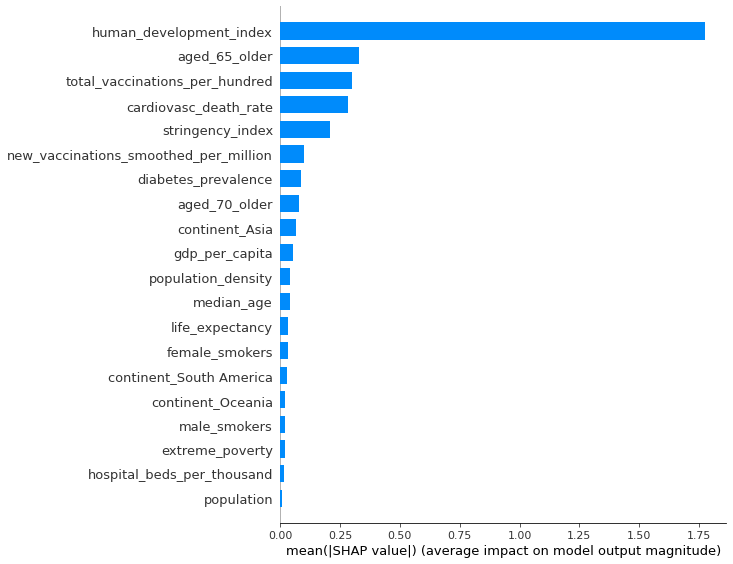

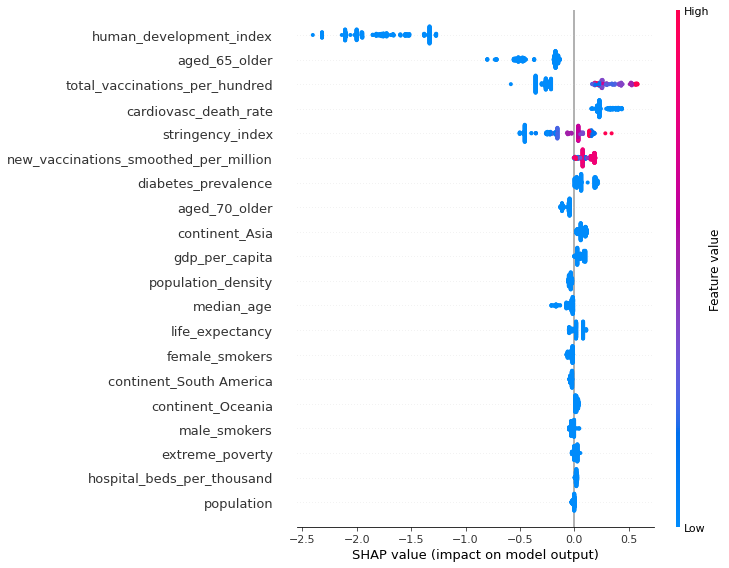

    total_vaccinations_per_hundred  new_vaccinations_smoothed_per_million  \
50                             6.9                                 1211.0   

    stringency_index  population  population_density  median_age  \
50             40.74  31732128.0             126.719        21.1   

    aged_65_older  aged_70_older  gdp_per_capita  extreme_poverty  ...  \
50          3.385          1.948         4227.63             12.0  ...   

    continent_Africa  continent_Asia  continent_Europe  \
50                 1               0                 0   

    continent_North America  continent_Oceania  continent_South America  \
50                        0                  0                        0   

    tests_units_people tested  tests_units_samples tested  \
50                          0                           1   

    tests_units_tests performed  tests_units_units unclear  
50                            0                          0  

[1 rows x 27 columns]


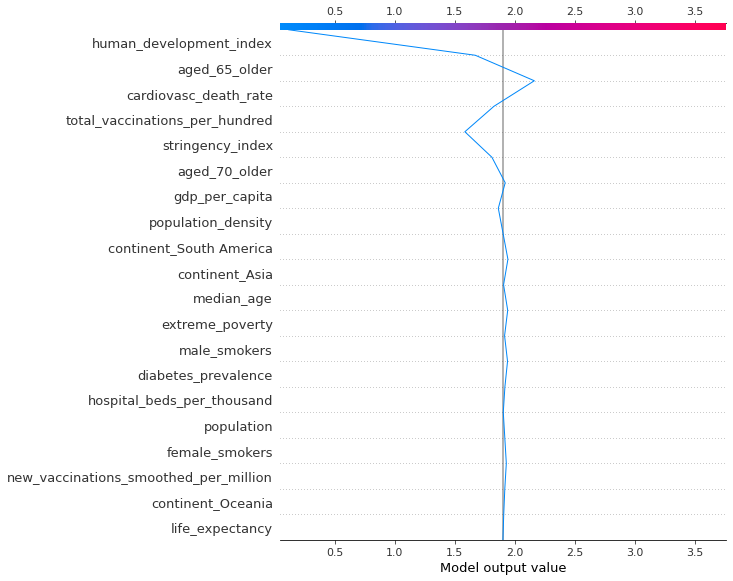

In [287]:
explain_country(ghana)  
#young, underdeveloped society with negative impact of cardiovasc health problems

## 2. Explainable AI - South Korea case

In [288]:
korea = X_test[X_test['location']=='South Korea'].drop(columns=['location'])

In [327]:
shap.force_plot(explainer.expected_value, explainer.shap_values(korea.reset_index(drop=True).iloc[[50]]),  korea.reset_index(drop=True).iloc[[50]])

In [344]:
shap.force_plot(explainer.expected_value, explainer.shap_values(korea.reset_index(drop=True).iloc[[300]]),  korea.reset_index(drop=True).iloc[[300]])

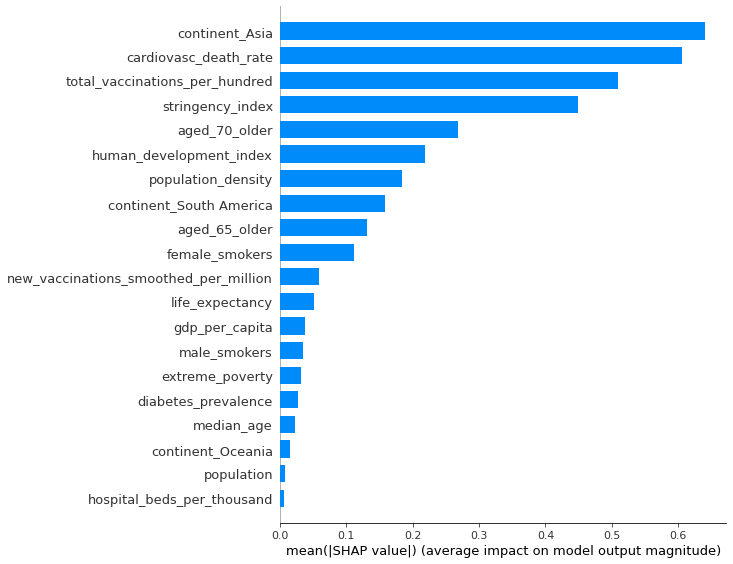

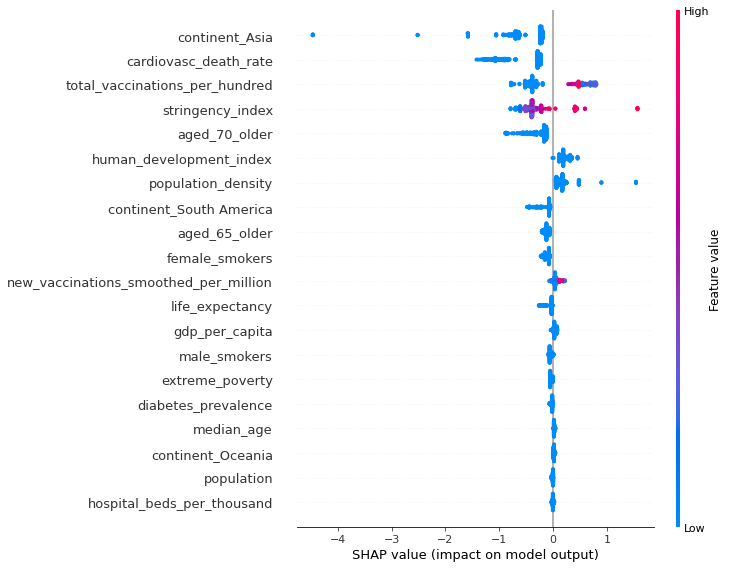

    total_vaccinations_per_hundred  new_vaccinations_smoothed_per_million  \
50                            0.08                                   34.0   

    stringency_index  population  population_density  median_age  \
50             75.93  51305184.0             527.967        43.4   

    aged_65_older  aged_70_older  gdp_per_capita  extreme_poverty  ...  \
50         13.914          8.622       35938.374              0.2  ...   

    continent_Africa  continent_Asia  continent_Europe  \
50                 0               1                 0   

    continent_North America  continent_Oceania  continent_South America  \
50                        0                  0                        0   

    tests_units_people tested  tests_units_samples tested  \
50                          1                           0   

    tests_units_tests performed  tests_units_units unclear  
50                            0                          0  

[1 rows x 27 columns]


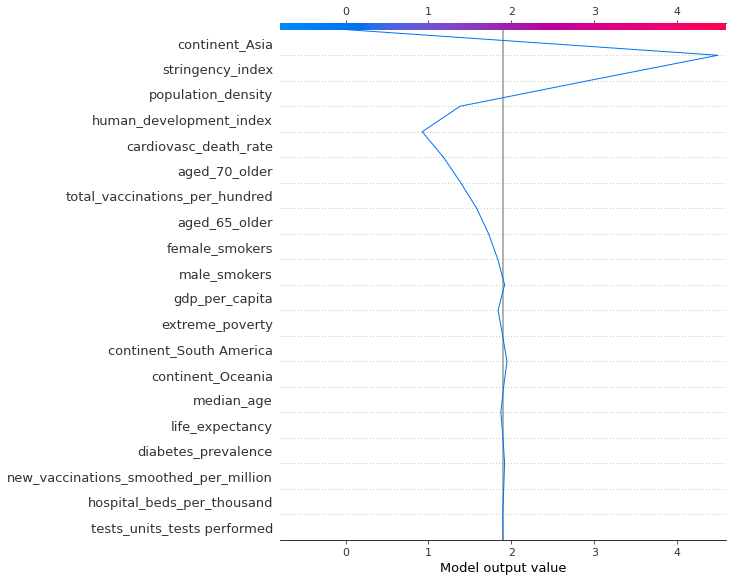

In [289]:
explain_country(korea) 
#Asian, healthy (low death rate from cardiovascular disease) and vaccinated country
#Average number of elderly people had positive impact
#Dense population helps virus spread

## 3. Explainable AI - Australia case

In [298]:
australia = X_test[X_test['location']=='Australia'].drop(columns=['location'])

In [328]:
shap.force_plot(explainer.expected_value, explainer.shap_values(australia.reset_index(drop=True).iloc[[50]]),  australia.reset_index(drop=True).iloc[[50]])

In [345]:
shap.force_plot(explainer.expected_value, explainer.shap_values(australia.reset_index(drop=True).iloc[[300]]),  australia.reset_index(drop=True).iloc[[300]])

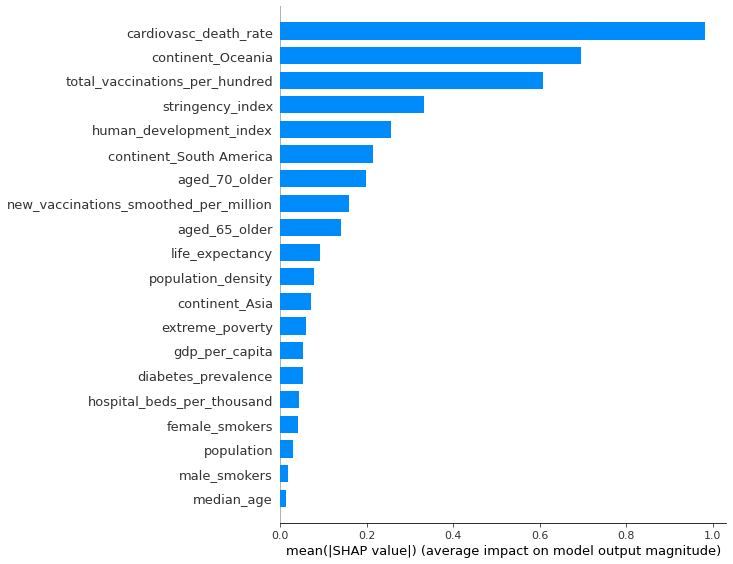

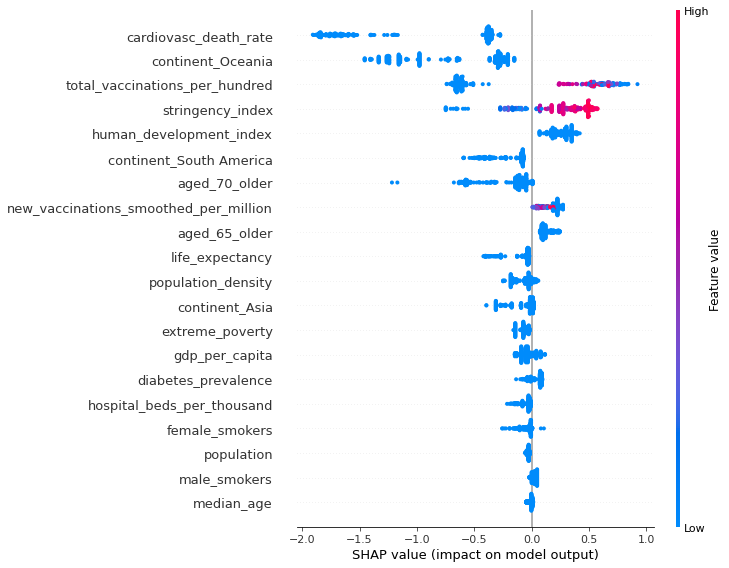

    total_vaccinations_per_hundred  new_vaccinations_smoothed_per_million  \
50                            18.0                                 4077.0   

    stringency_index  population  population_density  median_age  \
50             75.46  25788217.0               3.202        37.9   

    aged_65_older  aged_70_older  gdp_per_capita  extreme_poverty  ...  \
50         15.504         10.129        44648.71              0.5  ...   

    continent_Africa  continent_Asia  continent_Europe  \
50                 0               0                 0   

    continent_North America  continent_Oceania  continent_South America  \
50                        0                  1                        0   

    tests_units_people tested  tests_units_samples tested  \
50                          0                           0   

    tests_units_tests performed  tests_units_units unclear  
50                            1                          0  

[1 rows x 27 columns]


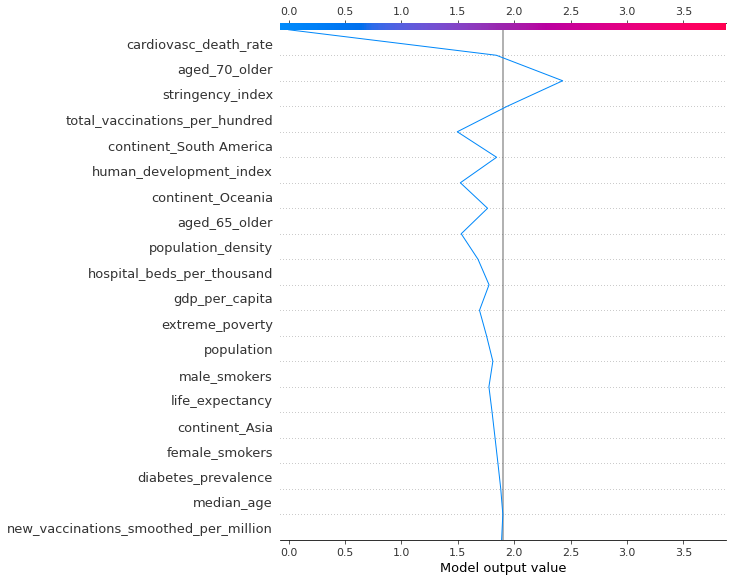

In [299]:
explain_country(australia) 
#healthy (low death rate from cardiovascular disease) country in Oceania
#average number of elderly people

## 4. Explainable AI - Brazil case

In [300]:
brazil = X_test[X_test['location']=='Brazil'].drop(columns=['location'])

In [329]:
shap.force_plot(explainer.expected_value, explainer.shap_values(brazil.reset_index(drop=True).iloc[[50]]),  brazil.reset_index(drop=True).iloc[[50]])

In [347]:
shap.force_plot(explainer.expected_value, explainer.shap_values(brazil.reset_index(drop=True).iloc[[250]]),  brazil.reset_index(drop=True).iloc[[250]])

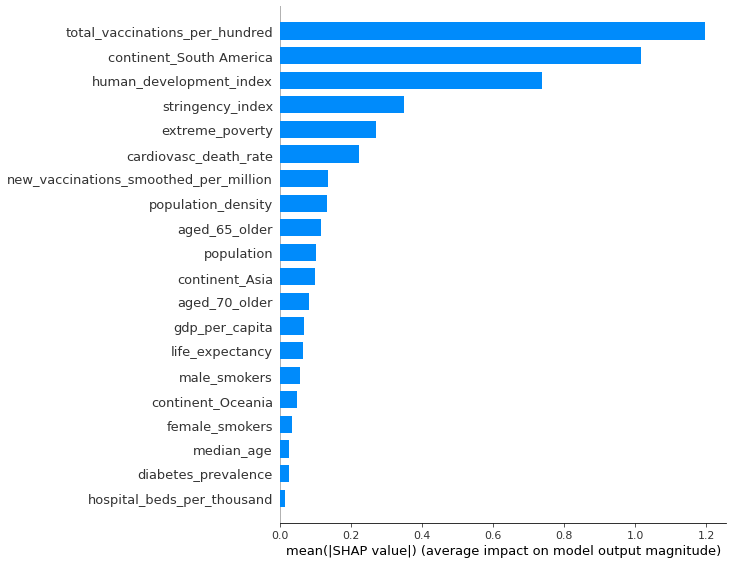

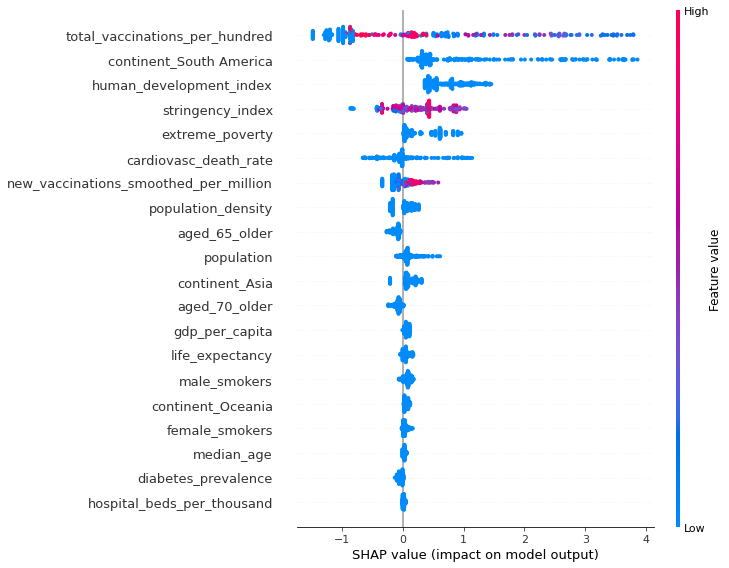

    total_vaccinations_per_hundred  new_vaccinations_smoothed_per_million  \
50                            4.13                                 1031.0   

    stringency_index   population  population_density  median_age  \
50             67.13  213993441.0               25.04        33.5   

    aged_65_older  aged_70_older  gdp_per_capita  extreme_poverty  ...  \
50          8.552           5.06       14103.452              3.4  ...   

    continent_Africa  continent_Asia  continent_Europe  \
50                 0               0                 0   

    continent_North America  continent_Oceania  continent_South America  \
50                        0                  0                        1   

    tests_units_people tested  tests_units_samples tested  \
50                          0                           0   

    tests_units_tests performed  tests_units_units unclear  
50                            1                          0  

[1 rows x 27 columns]


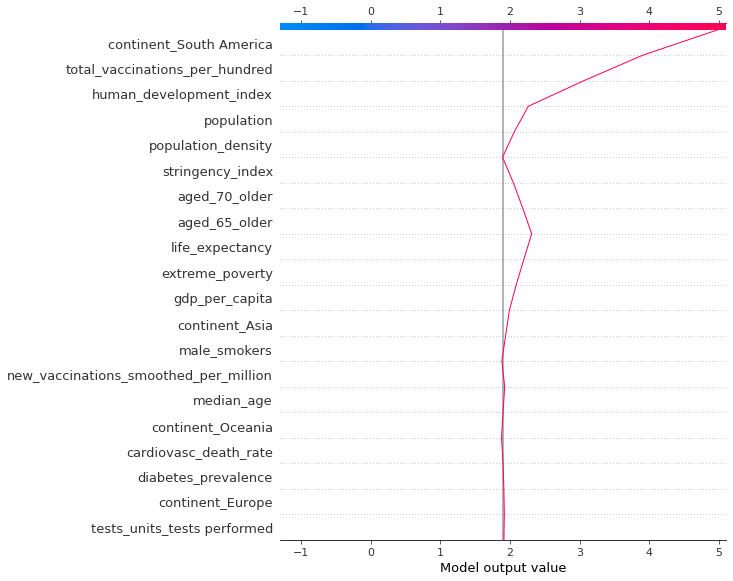

In [301]:
explain_country(brazil)  
#low level of vaccinations, South American country with middle HDI 
#Big poverty but lockdown and vaccination had some positive impact

## 5. Explainable AI - USA case

In [302]:
usa = X_test[X_test['location']=='United States'].drop(columns=['location'])

In [330]:
shap.force_plot(explainer.expected_value, explainer.shap_values(usa.reset_index(drop=True).iloc[[50]]),  usa.reset_index(drop=True).iloc[[50]])

In [348]:
shap.force_plot(explainer.expected_value, explainer.shap_values(usa.reset_index(drop=True).iloc[[300]]),  usa.reset_index(drop=True).iloc[[300]])

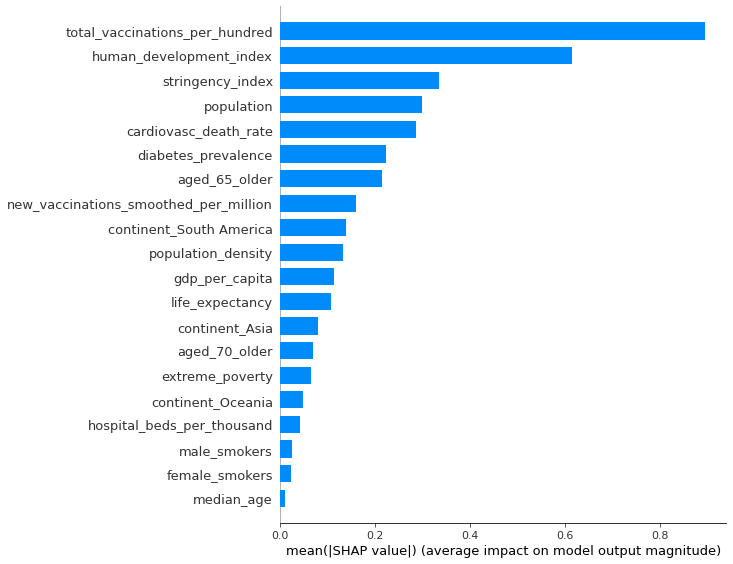

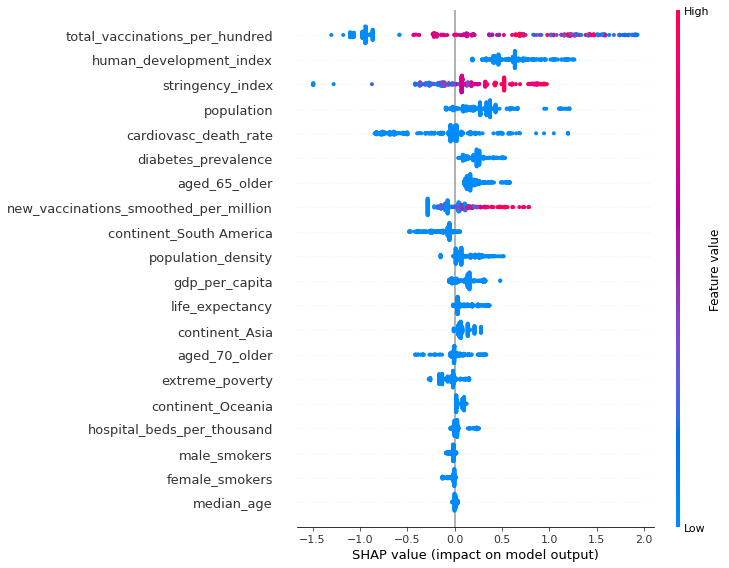

    total_vaccinations_per_hundred  new_vaccinations_smoothed_per_million  \
50                          116.42                                 2024.0   

    stringency_index   population  population_density  median_age  \
50             52.31  332915074.0              35.608        38.3   

    aged_65_older  aged_70_older  gdp_per_capita  extreme_poverty  ...  \
50         15.413          9.732       54225.446              1.2  ...   

    continent_Africa  continent_Asia  continent_Europe  \
50                 0               0                 0   

    continent_North America  continent_Oceania  continent_South America  \
50                        1                  0                        0   

    tests_units_people tested  tests_units_samples tested  \
50                          0                           0   

    tests_units_tests performed  tests_units_units unclear  
50                            1                          0  

[1 rows x 27 columns]


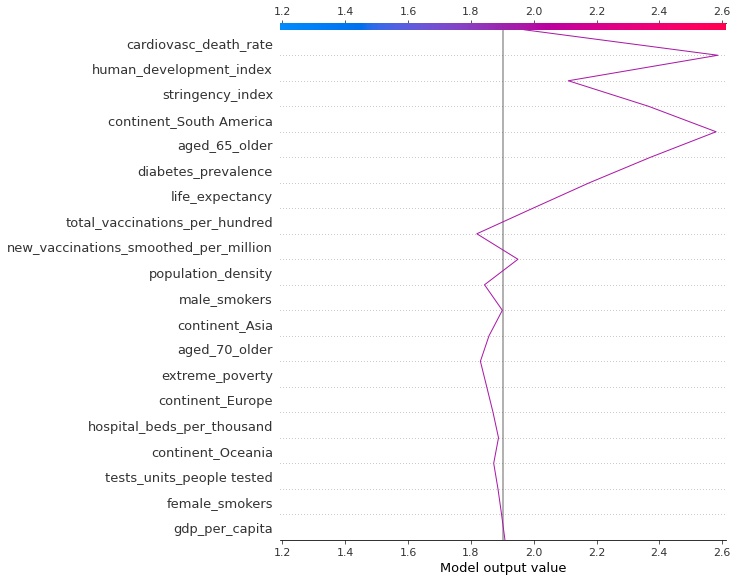

In [303]:
explain_country(usa)
# Negative impact of lack of lockdowns and vaccinations
# Developed country with big population (with bigger elderly share)
# positive effect of smaller value of cardiovasc death rate

## 6. Explainable AI - Italy case

In [304]:
italy = X_test[X_test['location']=='Italy'].drop(columns=['location'])

In [331]:
shap.force_plot(explainer.expected_value, explainer.shap_values(italy.reset_index(drop=True).iloc[[50]]),  italy.reset_index(drop=True).iloc[[50]])

In [350]:
shap.force_plot(explainer.expected_value, explainer.shap_values(italy.reset_index(drop=True).iloc[[300]]),  italy.reset_index(drop=True).iloc[[300]])

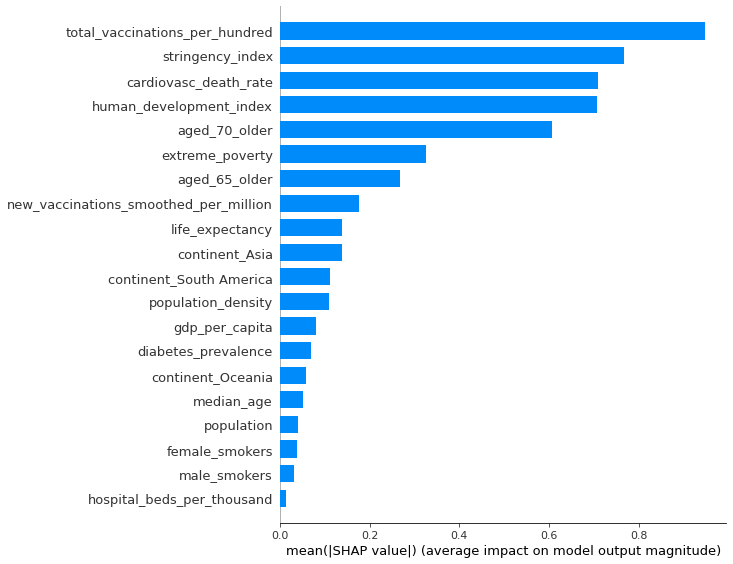

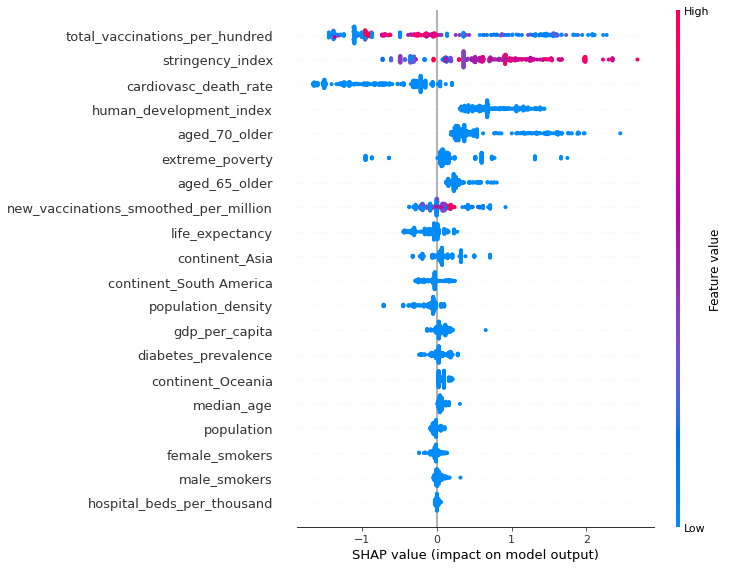

    total_vaccinations_per_hundred  new_vaccinations_smoothed_per_million  \
50                            0.01                                   25.0   

    stringency_index  population  population_density  median_age  \
50             65.74  60367471.0             205.859        47.9   

    aged_65_older  aged_70_older  gdp_per_capita  extreme_poverty  ...  \
50         23.021          16.24       35220.084              2.0  ...   

    continent_Africa  continent_Asia  continent_Europe  \
50                 0               0                 1   

    continent_North America  continent_Oceania  continent_South America  \
50                        0                  0                        0   

    tests_units_people tested  tests_units_samples tested  \
50                          0                           0   

    tests_units_tests performed  tests_units_units unclear  
50                            1                          0  

[1 rows x 27 columns]


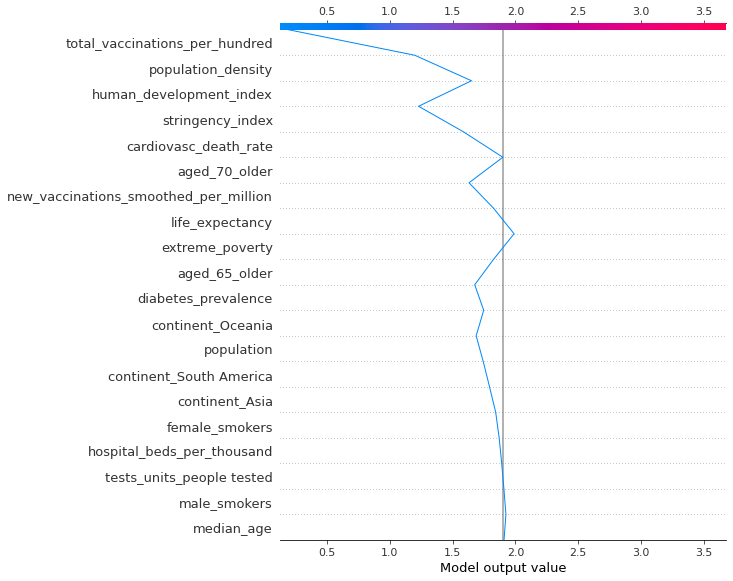

In [305]:
explain_country(italy) 
# Quite healthy (low death rate from cardiovascular disease) developed country with many elderly people
# higher population density and higher life exptectancy 

## Analysing average lockdown level around the world in 2021

## Data preparation

In [3]:
data = pd.read_csv('owid-covid-data-1.csv')

In [4]:
data = data[data['date']>= '2021-01-01'] 

In [5]:
data = data[['iso_code','date','location','stringency_index']]

In [6]:
data = data.dropna()

In [7]:
data = data.groupby('iso_code') \
       .agg({'iso_code':'size', 'stringency_index':'mean'}) \
       .rename(columns={'iso_code':'count','stringency_index':'mean'}) \
       .reset_index()

In [8]:
data = data[data['count']>=300] 

## Data viz

In [9]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

In [10]:
world = world.merge(data, left_on = "iso_a3", right_on = "iso_code", how='left')

<AxesSubplot:>

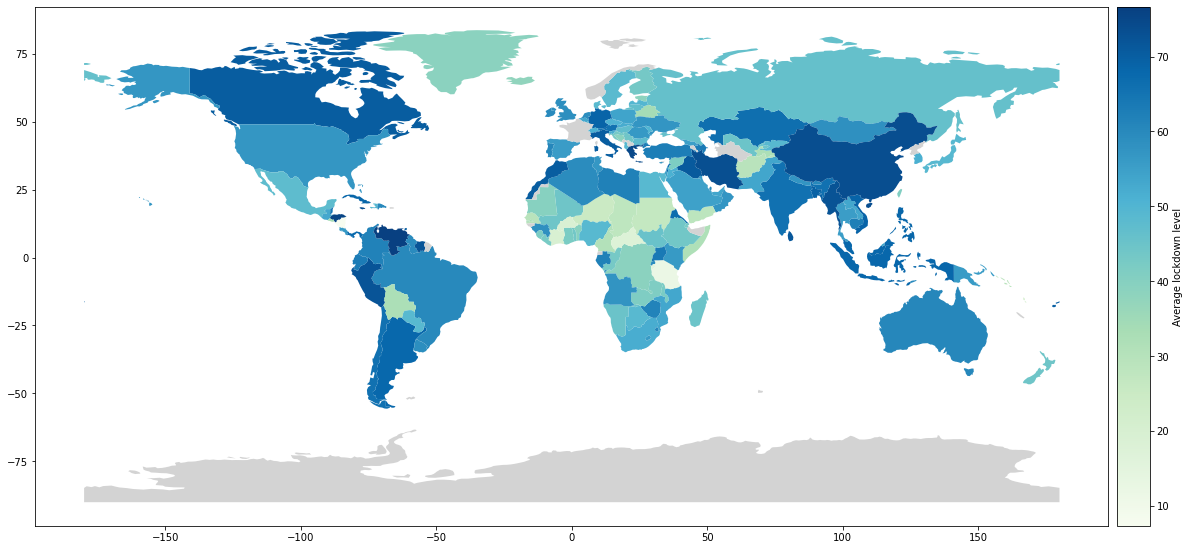

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(20, 20))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.1)

world.plot(column = 'mean', ax=ax, legend=True, cax=cax, 
           cmap='GnBu', missing_kwds={'color': 'lightgrey'}, legend_kwds={'label': "Average lockdown level"})

## Clustering by lockdown strictness 

In [16]:
conditions = [
    (world['mean'] > 65),
    (world['mean'] > 50) & (world['mean'] <= 65),
    (world['mean'] > 35) & (world['mean'] <= 50),
    (world['mean'] <= 35)
    ]

values = ['very strict', 'strict', 'moderate', 'liberal']

world['lockdown_lvl'] = np.select(conditions, values)

world.groupby('lockdown_lvl') \
       .agg({'lockdown_lvl':'size', 'mean':'mean'}) \
       .rename(columns={'lockdown_lvl':'count','mean':'group_mean'}) \
       .reset_index()

,lockdown_lvl,count,group_mean
0,0,18,NaN
1,liberal,21,25.548338
2,moderate,45,44.536674
3,strict,61,57.355573
4,very strict,32,69.856900


In [18]:
world.sort_values(by='mean', ascending=False).head(10)  #The most strict countries

,pop_est,continent,name,iso_a3,gdp_md_est,geometry,iso_code,count,mean,lockdown_lvl
40,31304016,South America,Venezuela,VEN,468600.0,"POLYGON ((-60.73357 5.20028, -60.60118 4.91810...",VEN,368.0,76.694783,very strict
36,9038741,North America,Honduras,HND,43190.0,"POLYGON ((-83.14722 14.99583, -83.48999 15.016...",HND,365.0,75.431123,very strict
123,10768477,Europe,Greece,GRC,290500.0,"MULTIPOLYGON (((26.29000 35.29999, 26.16500 35...",GRC,374.0,74.950000,very strict
139,1379302771,Asia,China,CHN,21140000.0,"MULTIPOLYGON (((109.47521 18.19770, 108.65521 ...",CHN,347.0,73.508213,very strict
107,82021564,Asia,Iran,IRN,1459000.0,"POLYGON ((48.56797 29.92678, 48.01457 30.45246...",IRN,367.0,73.429891,very strict
46,2990561,North America,Jamaica,JAM,25390.0,"POLYGON ((-77.56960 18.49053, -76.89662 18.400...",JAM,345.0,73.173507,very strict
93,55123814,Asia,Myanmar,MMR,311100.0,"POLYGON ((100.11599 20.41785, 99.54331 20.1866...",MMR,375.0,72.501093,very strict
42,591919,South America,Suriname,SUR,8547.0,"POLYGON ((-54.52475 2.31185, -55.09759 2.52375...",SUR,360.0,72.290111,very strict
31,31036656,South America,Peru,PER,410400.0,"POLYGON ((-69.89364 -4.29819, -70.79477 -4.251...",PER,341.0,72.255455,very strict
138,22409381,Asia,Sri Lanka,LKA,236700.0,"POLYGON ((81.78796 7.52306, 81.63732 6.48178, ...",LKA,374.0,71.273583,very strict


In [19]:
world.sort_values(by='mean', ascending=True).head(10) #The most liberal countries

,pop_est,continent,name,iso_a3,gdp_md_est,geometry,iso_code,count,mean,lockdown_lvl
35,6025951,North America,Nicaragua,NIC,33550.0,"POLYGON ((-83.65561 10.93876, -83.89505 10.726...",NIC,370.0,7.293892,liberal
1,53950935,Africa,Tanzania,TZA,150600.0,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...",TZA,361.0,11.756925,liberal
75,11466756,Africa,Burundi,BDI,7892.0,"POLYGON ((30.46967 -2.41385, 30.52766 -2.80762...",BDI,368.0,15.117826,liberal
66,5625118,Africa,Central African Rep.,CAF,3206.0,"POLYGON ((27.37423 5.23394, 27.04407 5.12785, ...",CAF,374.0,17.497353,liberal
65,20107509,Africa,Burkina Faso,BFA,32990.0,"POLYGON ((-5.40434 10.37074, -5.47056 10.95127...",BFA,339.0,19.133658,liberal
60,24184810,Africa,Côte d'Ivoire,CIV,87120.0,"POLYGON ((-8.02994 10.20653, -7.89959 10.29738...",CIV,373.0,19.635308,liberal
89,282814,Oceania,Vanuatu,VUT,723.0,"MULTIPOLYGON (((167.21680 -15.89185, 167.84488...",VUT,368.0,21.268913,liberal
55,19245344,Africa,Niger,NER,20150.0,"POLYGON ((14.85130 22.86295, 15.09689 21.30852...",NER,354.0,25.143305,liberal
14,37345935,Africa,Sudan,SDN,176300.0,"POLYGON ((24.56737 8.22919, 23.80581 8.66632, ...",SDN,340.0,26.757118,liberal
15,12075985,Africa,Chad,TCD,30590.0,"POLYGON ((23.83766 19.58047, 23.88689 15.61084...",TCD,361.0,28.015623,liberal


very strict
strict
moderate
liberal


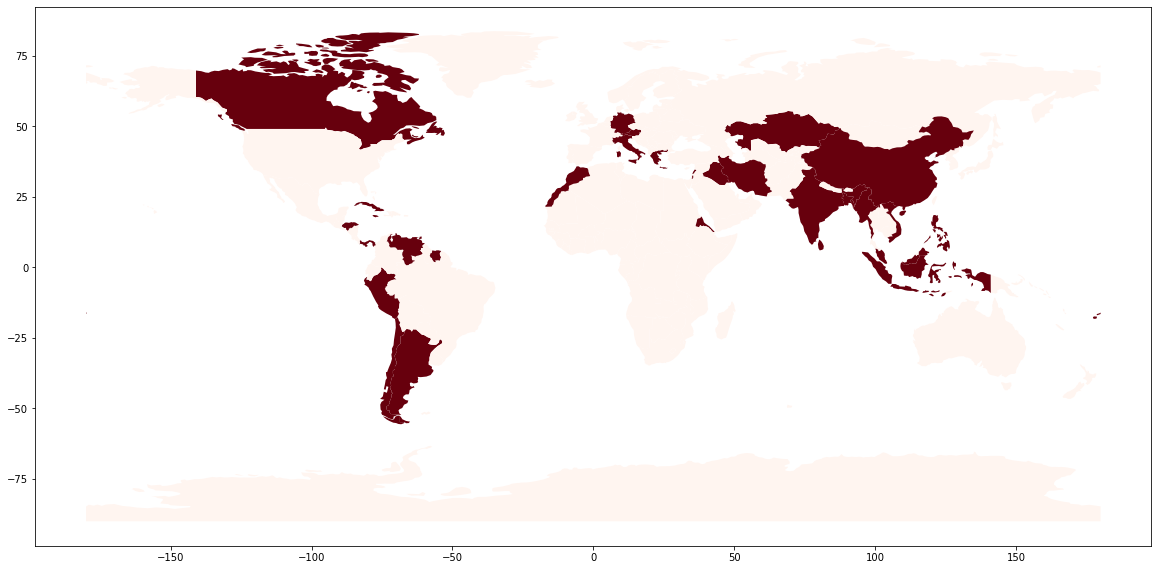

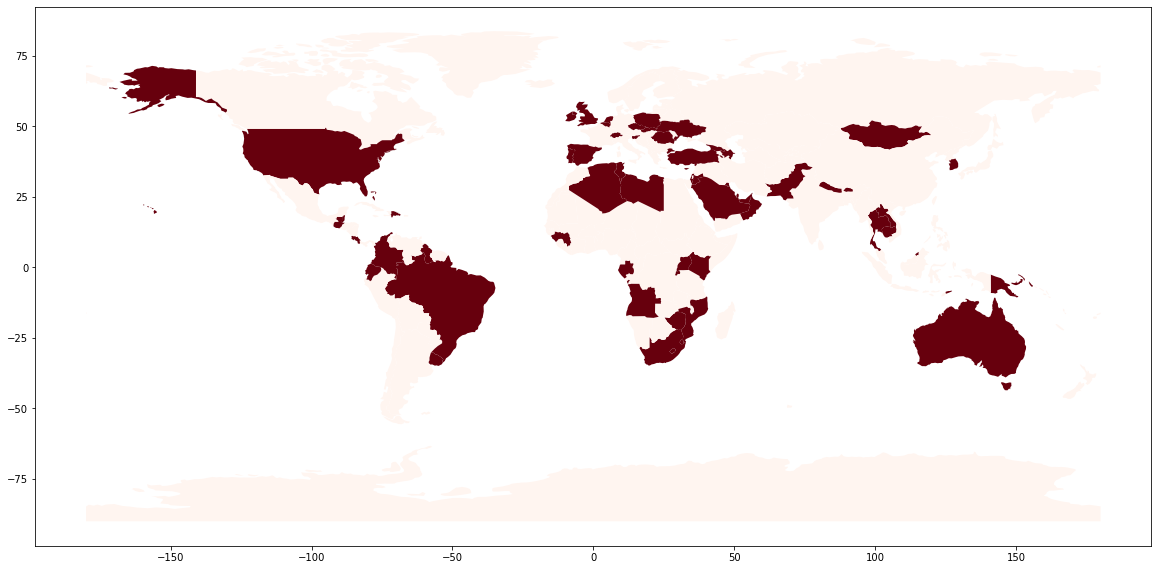

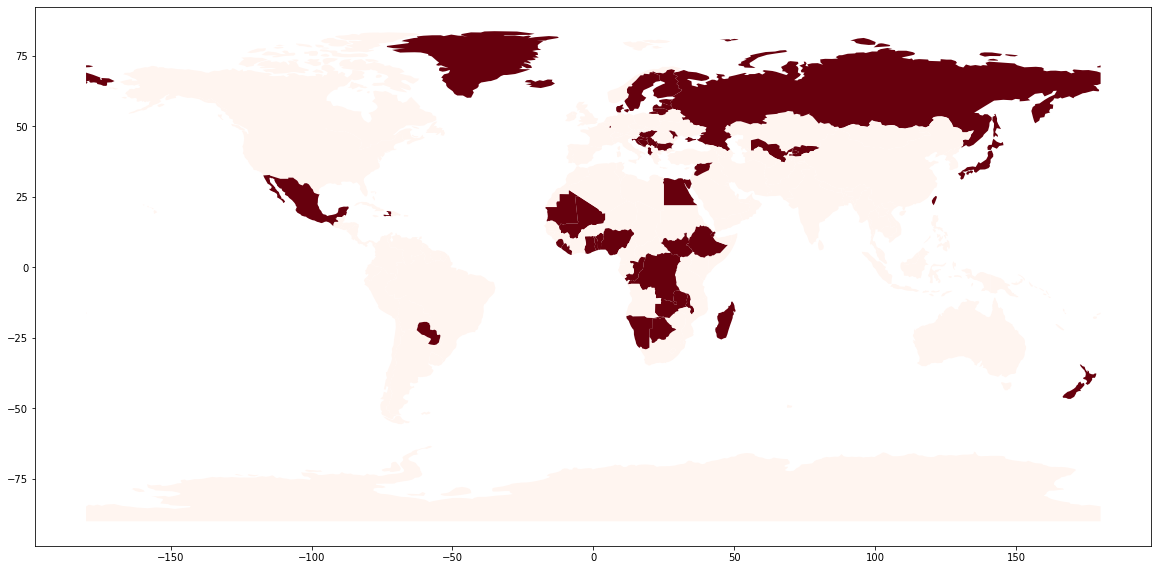

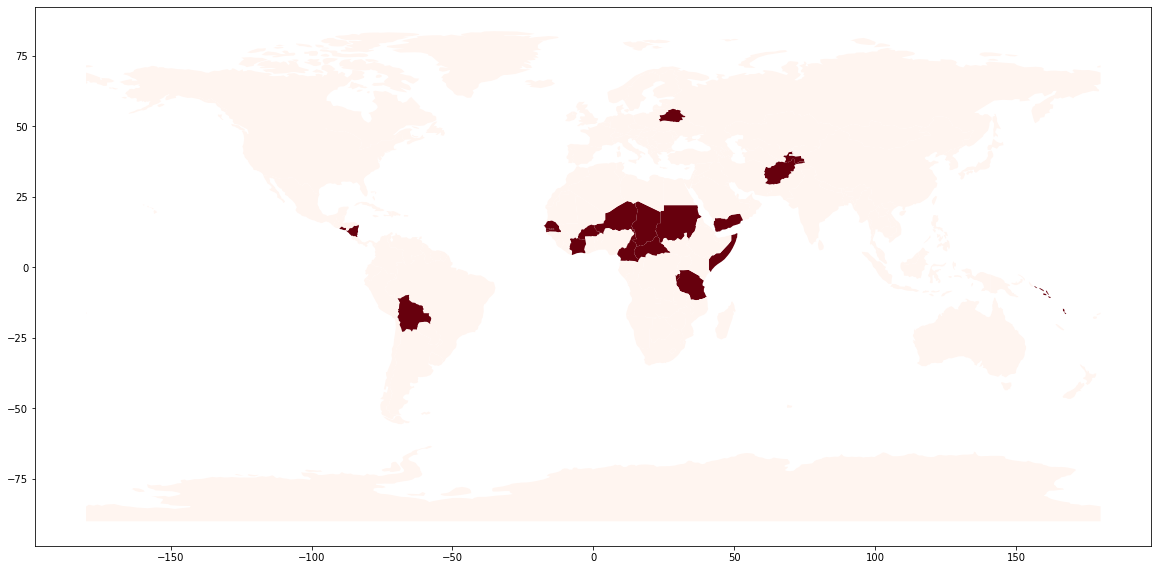

In [20]:
for value in values:
    print(value)
    world['temp'] = np.where(world['lockdown_lvl']== value, 1, 0)
    fig, ax = plt.subplots(1, 1, figsize=(20, 20))
    world.plot(column = 'temp', ax=ax, legend=False, cmap='Reds')